In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pinocchio
%matplotlib widget
import matplotlib as mpl
import matplotlib.animation as animation

In [2]:
model = pinocchio.buildModelFromUrdf("../learn_embedding/data/toycase/2_joints_arm.urdf")
data = model.createData()

q = np.array([0,0]) # [0,0], [0.05,0], [0.01,-0.01], [0.03, 0.0], [-0.02, 0.01], [0.07,0.01], [0.09, -0.01]
q_dot = np.array([0.0, 0.0])

q_t = np.array([-0.5, -0.5])
x_t = np.array([1.0, 1.5])

T = 20.0
dt = 0.01  # 1ms

states = np.concatenate((q, q_dot, np.zeros(2)))[np.newaxis]

In [3]:
for i in np.arange(0, T, dt):
    # configuration space control
    tau_config = -1.0*(q-q_t) - 1.0*q_dot

    # jacobian
    J = pinocchio.computeFrameJacobian(model, data, q, model.getFrameId("ee"), pinocchio.LOCAL_WORLD_ALIGNED)
    J = J[:2, :2]
    # task position
    pinocchio.forwardKinematics(model, data, q)
    x = pinocchio.updateFramePlacement(model, data, model.getFrameId("ee")).translation[:2]
    # task velocity
    x_dot = J.dot(q_dot)
    # task space control
    tau_task = - J.T.dot(0.1*(x-x_t) + 0.5*x_dot) + pinocchio.computeGeneralizedGravity(model, data, q)

    a = pinocchio.aba(model, data, q, q_dot, tau_task)
    q_dot = q_dot + dt*a
    q = q + dt*q_dot

    states[-1][-2:] = a
    states = np.append(states, np.concatenate((q, q_dot, np.zeros(2)))[np.newaxis], axis=0)
    
np.savetxt("../learn_embedding/data/toycase/trajectory_1_red.csv", states)

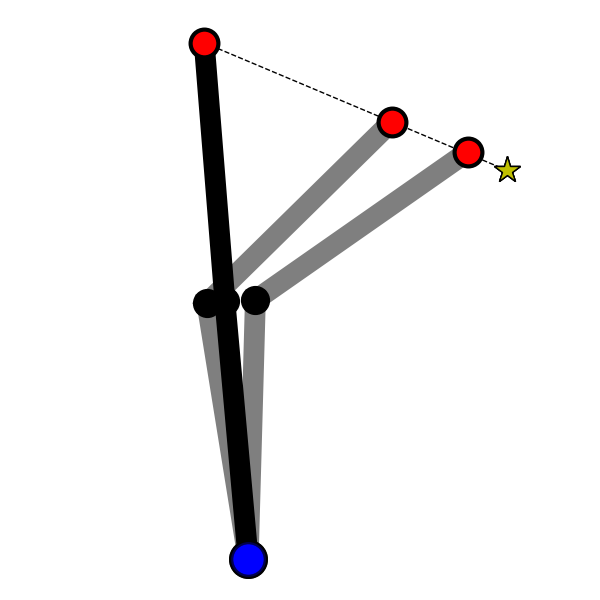

In [6]:
def plot_robot(q, model, data):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    for k in range(q.shape[0]):
        # Compute forward kinematics
        pinocchio.forwardKinematics(model, data, q[k, :])
        frames = data.oMi.tolist()

        # Plot the target point with a border
        ax.plot(x_t[0], x_t[1], 'y*', markersize=20, markeredgecolor='black', markeredgewidth=1)

        # Plot the base of the robotic arm with a border
        alpha = 1.0 if k == 0 else 0.5  # Adjust opacity based on configuration index
        ax.plot(frames[1].translation[0], frames[1].translation[1], 'bo', markersize=25, alpha=alpha,
                markeredgecolor='black', markeredgewidth=3, zorder=10)

        # Plot the links and joints of the robotic arm with borders
        for i in range(1, len(frames)-1):
            p0 = frames[i].translation
            p1 = frames[i+1].translation
            ax.plot([p0[0], p1[0]], [p0[1], p1[1]], 'k-', linewidth=15, alpha=alpha)  # Link
            ax.plot(p1[0], p1[1], 'ko', markersize=20, markeredgecolor='black', markeredgewidth=1, zorder=10)  # Joint

        # Plot the end effector of the robotic arm with a border
        ee_id = model.getFrameId("ee")
        p_ee = pinocchio.updateFramePlacement(model, data, ee_id).translation
        ax.plot([p1[0], p_ee[0]], [p1[1], p_ee[1]], 'k-', linewidth=15, alpha=alpha)  # Link
        ax.plot(p_ee[0], p_ee[1], 'ro', markersize=20, markeredgecolor='black', markeredgewidth=3, zorder=10)

        if k == 0:
            # Plot a dashed line connecting the first configuration's tip to the target
            ax.plot([p_ee[0], x_t[0]], [p_ee[1], x_t[1]], 'k--', linewidth=1, alpha=alpha)

    # Set the x and y limits of the plot
    ax.set_xlim([-2.0, 2.0])
    ax.set_ylim([-2.0, 2.0])

    # Set the aspect ratio to equal
    ax.set_aspect('equal')

    # Add a surrounding frame
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(0)
    ax.spines['left'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)

    # Add gridlines
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    # Center the plot
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-0.9, 1.3)
    ax.set_ylim(-0.1, 2.1)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Adjust layout
    fig.tight_layout()

    # Save the plot
    fig.savefig('../outputs/robot_motion.png', format='png', dpi=300, bbox_inches="tight")
    
# q_list = np.stack((states[0, :2], states[5000, :2], states[10000, :2]))
q_list = np.stack((states[0, :2], states[500, :2], states[1000, :2]))
plot_robot(q_list, model, data)

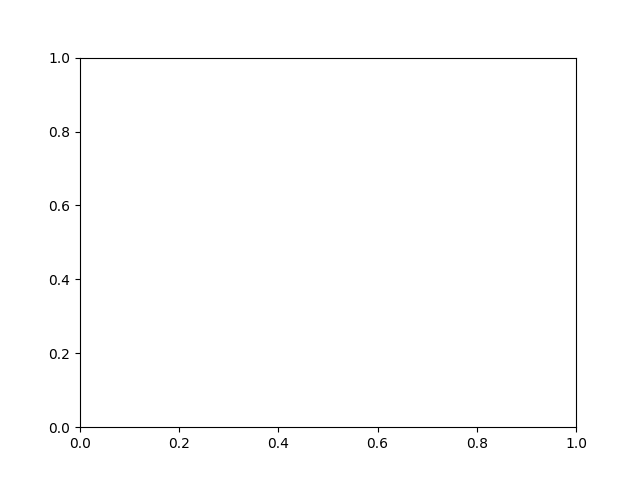

In [7]:
def animate_robot(i):
    q = states[i][:2]
    ax.clear()

    ax.plot(x_t[0], x_t[1], 'y*')

    pinocchio.forwardKinematics(model, data, q)
    frames = data.oMi.tolist()

    ax.plot(frames[1].translation[0], frames[1].translation[1], 'bo')  # Base
    for i in range(1, len(frames)-1):
        p0 = frames[i].translation
        p1 = frames[i+1].translation
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], 'k-', linewidth=2)  # Link 1
        ax.plot(p1[0], p1[1], 'ko')  # Joint

    ee_id = model.getFrameId("ee")
    p_ee = pinocchio.updateFramePlacement(model, data, ee_id).translation
    ax.plot([p1[0], p_ee[0]], [p1[1], p_ee[1]], 'k-', linewidth=2)  # Link 1
    ax.plot(p_ee[0], p_ee[1], 'ro')
    ax.set_xlim([-2.0, 2.0])
    ax.set_ylim([-2.0, 2.0])
    ax.set_aspect('equal')
    
fig, ax = plt.subplots()
step = int(np.round(0.016/dt))
ani = animation.FuncAnimation(fig, animate_robot, frames=np.arange(0, states.shape[0], step, dtype=np.intc), interval=step*dt*1000, repeat=False)

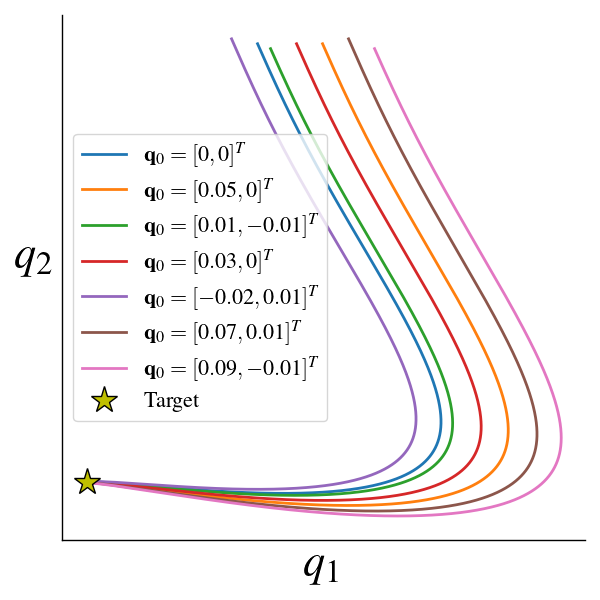

In [24]:
states_1 = np.loadtxt("../learn_embedding/data/toycase/trajectory_1.csv")
states_2 = np.loadtxt("../learn_embedding/data/toycase/trajectory_2.csv")
states_3 = np.loadtxt("../learn_embedding/data/toycase/trajectory_3.csv")
states_4 = np.loadtxt("../learn_embedding/data/toycase/trajectory_4.csv")
states_5 = np.loadtxt("../learn_embedding/data/toycase/trajectory_5.csv")
states_6 = np.loadtxt("../learn_embedding/data/toycase/trajectory_6.csv")
states_7 = np.loadtxt("../learn_embedding/data/toycase/trajectory_7.csv")

# Enable LaTeX rendering
mpl.rcParams['text.usetex'] = True

# Set Times as the font family
mpl.rcParams['font.family'] = 'Times'

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(states_1[:, 0], states_1[:, 1], linewidth=2, label='$\mathbf{q}_0 = [0,0]^T$')
ax.plot(states_2[:, 0], states_2[:, 1], linewidth=2, label='$\mathbf{q}_0 = [0.05,0]^T$')
ax.plot(states_3[:, 0], states_3[:, 1], linewidth=2, label='$\mathbf{q}_0 = [0.01,-0.01]^T$')
ax.plot(states_4[:, 0], states_4[:, 1], linewidth=2, label='$\mathbf{q}_0 = [0.03,0]^T$')
ax.plot(states_5[:, 0], states_5[:, 1], linewidth=2, label='$\mathbf{q}_0 = [-0.02,0.01]^T$')
ax.plot(states_6[:, 0], states_6[:, 1], linewidth=2, label='$\mathbf{q}_0 = [0.07,0.01]^T$')
ax.plot(states_7[:, 0], states_7[:, 1], linewidth=2, label='$\mathbf{q}_0 = [0.09,-0.01]^T$')

target_x = 0.5  # X-coordinate of the target
target_y = 0.7  # Y-coordinate of the target
ax.plot(states_4[-1, 0], states_4[-1, 1], 'y*', markersize=20, label='Target',  markeredgecolor='black', markeredgewidth=1)

ax.legend(loc='center left', fontsize=16)

ax.set_xlabel('$q_1$', fontsize=32)
ax.set_ylabel('$q_2$', fontsize=32, rotation=0, labelpad=20)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(0)


# Adjust layout
fig.tight_layout()

fig.savefig('../outputs/robot_trajectories.png', format='png', dpi=300, bbox_inches="tight")